In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Initial Setup
Reading in the datafile and doing some updates to allow for better analysis

In [2]:
# read in initial data
df = pd.read_csv("data/sample_data.csv")
df.head(2)

,Year,Quarter,Month,Product,Revenue,Device,Format,Company
0,2019,Qtr 3,September,Core,29698,Mobile,Display,Apple
1,2019,Qtr 3,September,Core,4171,Desktop,Display,Apple


In [3]:
# setup columns as all lowercase
df.columns = df.columns.str.lower()

In [4]:
# create month number column
df['month_num'] = [datetime.strptime(x, '%B').month for x in df['month']]
df.head(2)

,year,quarter,month,product,revenue,device,format,company,month_num
0,2019,Qtr 3,September,Core,29698,Mobile,Display,Apple,9
1,2019,Qtr 3,September,Core,4171,Desktop,Display,Apple,9


In [5]:
# create datetime formatted column, combining year and month
df['date'] = pd.to_datetime(df['year'].astype(str) + '/' + df['month_num'].astype(str) + '/01', format="%Y/%m")

print(f"The date column is now datatype: {df['date'].dtypes} \n")
print(f"Current column order is: \n{df.columns}")

The date column is now datatype: datetime64[ns] 

Current column order is: 
Index(['year', 'quarter', 'month', 'product', 'revenue', 'device', 'format',
       'company', 'month_num', 'date'],
      dtype='object')


In [6]:
# reorder columns to group date fields (only readability reasons)
df = df[['date', 'year', 'quarter', 'month', 'month_num', 'company', 'product', 'device', 'format', 'revenue']]
df.head()

,date,year,quarter,month,month_num,company,product,device,format,revenue
0,2019-09-01,2019,Qtr 3,September,9,Apple,Core,Mobile,Display,29698
1,2019-09-01,2019,Qtr 3,September,9,Apple,Core,Desktop,Display,4171
2,2019-08-01,2019,Qtr 3,August,8,Apple,Core,Mobile,Display,88938
3,2019-08-01,2019,Qtr 3,August,8,Apple,Core,Desktop,Display,10154
4,2019-07-01,2019,Qtr 3,July,7,Apple,Core,Mobile,Display,85092


# Questions

## Question 1
In how many quarters did “Orange” have more than $15K in “Social” revenue?

In [7]:
# aggregate sum of revenue by year and quarter
year_qtr_df = df.groupby(['year', 'quarter', 'company', 'product']).agg({'revenue': 'sum'}).reset_index()

# filter by orange and social
orange_soc_df = year_qtr_df.loc[(year_qtr_df['revenue'] > 15000) & 
                (year_qtr_df['product'] == 'Social') &
                (year_qtr_df['company'] == 'Orange')]
orange_soc_df

,year,quarter,company,product,revenue
57,2017,Qtr 4,Orange,Social,27423
77,2018,Qtr 1,Orange,Social,59855
97,2018,Qtr 2,Orange,Social,79679
116,2018,Qtr 3,Orange,Social,75458
135,2018,Qtr 4,Orange,Social,75075
153,2019,Qtr 1,Orange,Social,52670
172,2019,Qtr 2,Orange,Social,75734
190,2019,Qtr 3,Orange,Social,77461


In [8]:
# answer question
orange_soc_count = len(orange_soc_df['revenue'])
print(f'Orange company has had {orange_soc_count} quarters with more than 15K in Social revenue')

Orange company has had 8 quarters with more than 15K in Social revenue


## Question 2
What was the average quarter-over-quarter (QoQ) growth in revenue among
companies from Q2 to Q3 in 2018?

In [9]:
# filter by 2018 quarters 2 and 3
Q2_Q3_2018_df = df[(df['date'].dt.year == 2018) & (df['date'].dt.quarter.isin([2,3]))]
print(f"unique years:  {Q2_Q3_2018_df['year'].unique()}")
print(f"unique quarters:  {Q2_Q3_2018_df['quarter'].unique()}")

unique years:  [2018]
unique quarters:  ['Qtr 3' 'Qtr 2']


In [10]:
# group by company, aggregate revenue
pivot_comp_rev_df = Q2_Q3_2018_df.pivot_table(index='company', columns='quarter', aggfunc={'revenue': 'sum'}).fillna(0)
pivot_comp_rev_df.head(2)

revenue          
quarter     Qtr 2     Qtr 3
company                    
Amazon    73947.0   50096.0
Apple    178898.0  156500.0

In [11]:
# I prefer to flatten the columns as opposed to the multi-index, so have this function I may use after pivoting data
def flatten_cols(df):
    df.columns = [
        '_'.join(tuple(map(str, t))).strip() 
        for t in df.columns.values
        ]
    return df

In [12]:
# flatten index
comp_rev_df = flatten_cols(pivot_comp_rev_df)
comp_rev_df.head(2)

,revenue_Qtr 2,revenue_Qtr 3
company,,
Amazon,73947.0,50096.0
Apple,178898.0,156500.0


In [13]:
# rename columns for readability and to be more explicit
comp_rev_df.columns = ['2018_Q2_revenue', '2018_Q3_revenue']

In [14]:
# add quarter over quarter change by company
comp_rev_df['QoQ_change_perc'] = ((comp_rev_df['2018_Q3_revenue'] / comp_rev_df['2018_Q2_revenue']) -1) * 100
comp_rev_df

,2018_Q2_revenue,2018_Q3_revenue,QoQ_change_perc
company,,,
Amazon,73947.0,50096.0,-32.254182
Apple,178898.0,156500.0,-12.519983
Ganges,147428.0,137777.0,-6.546246
Grape,194384.0,0.0,-100.000000
Kiwi,110770.0,134222.0,21.171797
Mississippi,128858.0,77362.0,-39.963371
Nile,49581.0,249745.0,403.711099
Orange,138005.0,165222.0,19.721749
Pear,40028.0,568973.0,1321.437494


In [15]:
# stats on quarter over quarter performance
QoQ_stats = comp_rev_df['QoQ_change_perc'].describe()
QoQ_stats

count      10.000000
mean      158.538277
std       430.970858
min      -100.000000
25%       -27.320632
50%         2.039084
75%        20.809285
max      1321.437494
Name: QoQ_change_perc, dtype: float64

In [16]:
# answer question

# average growth
print(f"The average growth of revenue by company from Q2-2018 to Q3-2018 was {QoQ_stats['mean'].round(1)}%")

# overall growth
overall_growth = (sum(comp_rev_df['2018_Q3_revenue']) / sum(comp_rev_df['2018_Q2_revenue']) -1 )* 100
print(f"The overall revenue growth from Q2-2018 to Q3-2018 was {round(overall_growth, 1)}%")

The average growth of revenue by company from Q2-2018 to Q3-2018 was 158.5%
The overall revenue growth from Q2-2018 to Q3-2018 was 36.7%


## Question 3
List the companies by the number of months they have spent as a client, in
descending order.


In [17]:
# answer question

# group by company and aggregate date by count
month_count_df = df.groupby(['company']).agg({'date': 'count'})
month_count_df = month_count_df.rename(columns={'date': 'count_of_months'})
month_count_df.sort_values(by='count_of_months', ascending=False).reset_index()

,company,count_of_months
0,Kiwi,255
1,Ganges,218
2,Amazon,216
3,Orange,205
4,Mississippi,201
5,Yangtze,66
6,Apple,52
7,Pear,16
8,Nile,15
9,Grape,7


## Question 4
In each year, what percentage of “Core” revenue has come from video?

In [18]:
# filter by only core product
core_df = df.loc[(df['product'] == "Core")]
core_df.head(2)

,date,year,quarter,month,month_num,company,product,device,format,revenue
0,2019-09-01,2019,Qtr 3,September,9,Apple,Core,Mobile,Display,29698
1,2019-09-01,2019,Qtr 3,September,9,Apple,Core,Desktop,Display,4171


In [19]:
# group by company, aggregate revenue
pivot_year_core_df = core_df.pivot_table(index='year', columns='format', aggfunc={'revenue': 'sum'}).fillna(0)

# flatten index
year_core_df = flatten_cols(pivot_year_core_df)

# add a total revenue column
year_core_df['core_revenue_total'] = year_core_df.sum(numeric_only=True, axis=1)
year_core_df

,revenue_Display,revenue_Video,core_revenue_total
year,,,
2017,3213743,14975,3228718
2018,6453001,22784,6475785
2019,3912259,25137,3937396


In [20]:
# convert to percentages
year_core_perc_df = year_core_df.div(year_core_df['core_revenue_total'], axis=0) * 100 
year_core_perc_df = year_core_perc_df.reset_index()
year_core_perc_df

,year,revenue_Display,revenue_Video,core_revenue_total
0,2017,99.536194,0.463806,100.0
1,2018,99.648166,0.351834,100.0
2,2019,99.361583,0.638417,100.0


In [21]:
# answer question
for row in year_core_perc_df.itertuples():
    print(f"In {row.year} Core product had a {round(row.revenue_Video, 2)}% of its revenue come from video")

print("\nOverall, a fairly small percentage at below 1% in each year")

In 2017 Core product had a 0.46% of its revenue come from video
In 2018 Core product had a 0.35% of its revenue come from video
In 2019 Core product had a 0.64% of its revenue come from video

Overall, a fairly small percentage at below 1% in each year


## Question 5
Which month saw the highest month-over-month (MoM) percent change in total
revenue?

In [22]:
# aggregate revenue by month
month_rev_df = df.groupby('date').agg({'revenue': 'sum'})
month_rev_df.head()

,revenue
date,
2017-01-01,188665
2017-02-01,230227
2017-03-01,304013
2017-04-01,195051
2017-05-01,243337


In [23]:
# create percent change column
month_rev_df['percent_change'] = (month_rev_df['revenue'].pct_change()) * 100
month_rev_df.head()

,revenue,percent_change
date,,
2017-01-01,188665,NaN
2017-02-01,230227,22.029523
2017-03-01,304013,32.049238
2017-04-01,195051,-35.841230
2017-05-01,243337,24.755577


In [24]:
# stats on percent change by month
max_revenue_chg = month_rev_df['percent_change'].max()

# year and month with highest revenue change
highest_month_chg = month_rev_df['percent_change'].idxmax().strftime("%Y-%m")

In [25]:
# answer question

print(f"{highest_month_chg} had the largest MoM revenue growth at {round(max_revenue_chg, 1)}%")

2017-12 had the largest MoM revenue growth at 60.7%


# Additional Analysis

In [26]:
## use pandas profiling package (to view you may need to pip install pandas-profiling)
## commented out: nothing too interesting from summary
# import pandas_profiling

# prof_report = pandas_profiling.ProfileReport(df , title = 'Summary Profile')
# prof_report.to_widgets()

## YOY Rolling Quarter
Show revenue performance of time. Using rolling quarters to avoid any monthly outlier interference. Will show:
 - Overall performance
 - YOY total change by rolling quarter
 - YOY percent change by rolling quarter

In [27]:
# create dataframe with rolling qtr revenue
qtr_df = df.pivot_table(index='date', aggfunc={'revenue': 'sum'}).fillna(0)
qtr_df['trailing_qtr_rev'] = qtr_df.rolling(3).sum().fillna(0)
qtr_df['yoy_qtr_rev_change'] = qtr_df['trailing_qtr_rev'] - qtr_df['trailing_qtr_rev'].shift(12)
qtr_df['yoy_qtr_rev_change_perc'] = (qtr_df['trailing_qtr_rev'] / qtr_df['trailing_qtr_rev'].shift(12) - 1) * 100

print("NaN are expected as there wouldn't be same periods the year prior for the earliest months in the dataset")
qtr_df.head()

NaN are expected as there wouldn't be same periods the year prior for the earliest months in the dataset


,revenue,trailing_qtr_rev,yoy_qtr_rev_change,yoy_qtr_rev_change_perc
date,,,,
2017-01-01,188665,0.0,NaN,NaN
2017-02-01,230227,0.0,NaN,NaN
2017-03-01,304013,722905.0,NaN,NaN
2017-04-01,195051,729291.0,NaN,NaN
2017-05-01,243337,742401.0,NaN,NaN


In [28]:
# limit to periods that have YOY comps
trim_qtr_df = qtr_df[14:].reset_index()

# change index to year and month only
trim_qtr_df['year_month_label'] = trim_qtr_df['date'].dt.to_period('m')

# create csv
trim_qtr_df.to_csv("data_exports/overall_qtr_sales.csv", index=False)

trim_qtr_df.head()

,date,revenue,trailing_qtr_rev,yoy_qtr_rev_change,yoy_qtr_rev_change_perc,year_month_label
0,2018-03-01,551398,1525107.0,802202.0,110.969214,2018-03
1,2018-04-01,503398,1582148.0,852857.0,116.943305,2018-04
2,2018-05-01,433739,1488535.0,746134.0,100.502828,2018-05
3,2018-06-01,464376,1401513.0,627169.0,80.993589,2018-06
4,2018-07-01,599930,1498045.0,702695.0,88.350412,2018-07


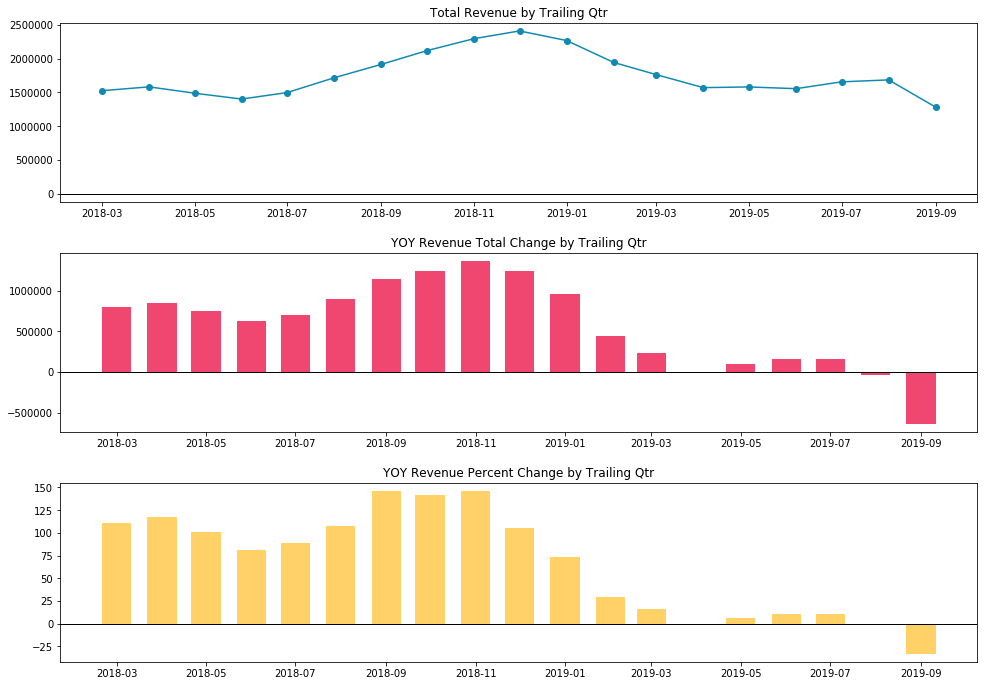

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
colors = ["#118AB2", "#EF476F", "#FFD166", "#06D6A0", "#EE754D", "#002E99"]

# plot rolling quarters
fig, axs = plt.subplots(3)
fig.set_size_inches(14, 10)
fig.tight_layout(pad=3)

axs[0].plot(trim_qtr_df['date'], trim_qtr_df['trailing_qtr_rev'], color=colors[0], marker="o")
axs[0].set_title("Total Revenue by Trailing Qtr")

axs[1].bar(trim_qtr_df['date'], trim_qtr_df['yoy_qtr_rev_change'], color=colors[1], width=20)
axs[1].set_title("YOY Revenue Total Change by Trailing Qtr")

axs[2].bar(trim_qtr_df['date'], trim_qtr_df['yoy_qtr_rev_change_perc'], color=colors[2], width=20)
axs[2].set_title("YOY Revenue Percent Change by Trailing Qtr")


# add horizontal line at 0 for all axes
for x in range(len(axs)):
    axs[x].axhline(y=0, color='black', linewidth=1)

plt.show()

## Rolling 24 Month Dataframe
Create a rolling 24 month dataframe which is going to be used for both the customer and product analysis sections

In [30]:
# get 24 month period for analysis
start_date = date(2017, 9, 1).strftime("%Y-%m-%d")
last_24mos = df.loc[df['date'] > start_date]
last_24mos['date'].describe()

count                    1003
unique                     24
top       2018-09-01 00:00:00
freq                       48
first     2017-10-01 00:00:00
last      2019-09-01 00:00:00
Name: date, dtype: object

In [31]:
# function which adds a YOY period for a rolling 24 months 
def add_yoy_period(df, period_id):
    """
    Dataframe specific function which is used to create a new column "yoy_period" that has last year and current year periods 
    distinctly identified. Must have 24 total periods (months).

    Parameters:
        df: the dataframe being used to derive yoy period from.
        col_name: the column you are using to derive the YOY periods (likely month, period, etc.)
  
    """
    # get the year over year periods
    periods = df[period_id].unique()
    periods_df = pd.DataFrame({period_id : periods}).sort_values(period_id, ascending=True)

    # get first 12 periods
    ly_period_df = periods_df.iloc[0:12, :]
    ly_period_df["yoy_period"] = "last year"

    # get last 12 periods
    cy_period_df = periods_df.iloc[12:, :]
    cy_period_df["yoy_period"] = "current year"

    periods_df = pd.concat([ly_period_df, cy_period_df])

    # merge with the existing dataframe
    df = df.merge(periods_df, on=period_id)

    return df

In [32]:
# add in a YOY period column
####################################
# Note: warning shouldn't be a problem, it is from the temporary table in the function that's merged with the 
# passed in dataframe and discarded
####################################

last_24mos_df = add_yoy_period(last_24mos, 'date')
last_24mos_df.head()

C:\Users\adamj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\adamj\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,year,quarter,month,month_num,company,product,device,format,revenue,yoy_period
0,2019-09-01,2019,Qtr 3,September,9,Apple,Core,Mobile,Display,29698,current year
1,2019-09-01,2019,Qtr 3,September,9,Apple,Core,Desktop,Display,4171,current year
2,2019-09-01,2019,Qtr 3,September,9,Pear,Core,Desktop,Display,55194,current year
3,2019-09-01,2019,Qtr 3,September,9,Orange,Social,Mobile,Video,3536,current year
4,2019-09-01,2019,Qtr 3,September,9,Orange,Social,Mobile,Display,1041,current year


## Customer Analysis
Will use the most recent rolling 24 months to hightlight current status and YOY change for customers. Show the following customer views:
 - Total revenue
 - YOY revenue change
 - Number of products
 - YOY change in number of products

### Year Over Year
Highlights YOY Trends

In [33]:
# get year over year customer revenue
cust_rev_pivot_df = last_24mos_df.pivot_table(index='company', columns='yoy_period', aggfunc={'revenue': 'sum'}).fillna(0)
cust_rev_df = flatten_cols(cust_rev_pivot_df)
cust_rev_df['yoy_revenue_chg'] = (cust_rev_df['revenue_current year'] / cust_rev_df['revenue_last year'] - 1) * 100
cust_rev_df = cust_rev_df.reset_index()
cust_rev_df

,company,revenue_current year,revenue_last year,yoy_revenue_chg
0,Amazon,174765.0,388213.0,-54.982188
1,Apple,896148.0,649654.0,37.942351
2,Ganges,249213.0,574901.0,-56.651145
3,Grape,0.0,718932.0,-100.000000
4,Kiwi,504376.0,339019.0,48.775142
5,Mississippi,450680.0,414979.0,8.603086
6,Nile,485294.0,299326.0,62.128916
7,Orange,581300.0,460682.0,26.182486
8,Pear,2398582.0,609001.0,293.855183
9,Yangtze,1270916.0,1561540.0,-18.611371


In [34]:
# get year over year product count
cust_prod_pivot_df = last_24mos_df.pivot_table(index='company', columns='yoy_period', values='product',
                                              aggfunc=pd.Series.nunique).fillna(0)

# columns editing
cust_prod_df = cust_prod_pivot_df.rename(columns={'current year': 'products_current year',
                                                'last year': 'products_last year'})
cust_prod_df.columns.name = None

# add yoy change
cust_prod_df['yoy_products_chg'] = (cust_prod_df['products_current year'] / cust_prod_df['products_last year'] - 1) * 100

cust_prod_df = cust_prod_df.reset_index()
cust_prod_df

,company,products_current year,products_last year,yoy_products_chg
0,Amazon,3.0,4.0,-25.000000
1,Apple,1.0,1.0,0.000000
2,Ganges,3.0,3.0,0.000000
3,Grape,0.0,1.0,-100.000000
4,Kiwi,4.0,3.0,33.333333
5,Mississippi,3.0,4.0,-25.000000
6,Nile,1.0,1.0,0.000000
7,Orange,4.0,4.0,0.000000
8,Pear,1.0,1.0,0.000000
9,Yangtze,1.0,1.0,0.000000


In [35]:
# merge the revenue and product count dataframes
cust_df = pd.merge(cust_rev_df, cust_prod_df)
cust_df

,company,revenue_current year,revenue_last year,yoy_revenue_chg,products_current year,products_last year,yoy_products_chg
0,Amazon,174765.0,388213.0,-54.982188,3.0,4.0,-25.000000
1,Apple,896148.0,649654.0,37.942351,1.0,1.0,0.000000
2,Ganges,249213.0,574901.0,-56.651145,3.0,3.0,0.000000
3,Grape,0.0,718932.0,-100.000000,0.0,1.0,-100.000000
4,Kiwi,504376.0,339019.0,48.775142,4.0,3.0,33.333333
5,Mississippi,450680.0,414979.0,8.603086,3.0,4.0,-25.000000
6,Nile,485294.0,299326.0,62.128916,1.0,1.0,0.000000
7,Orange,581300.0,460682.0,26.182486,4.0,4.0,0.000000
8,Pear,2398582.0,609001.0,293.855183,1.0,1.0,0.000000
9,Yangtze,1270916.0,1561540.0,-18.611371,1.0,1.0,0.000000


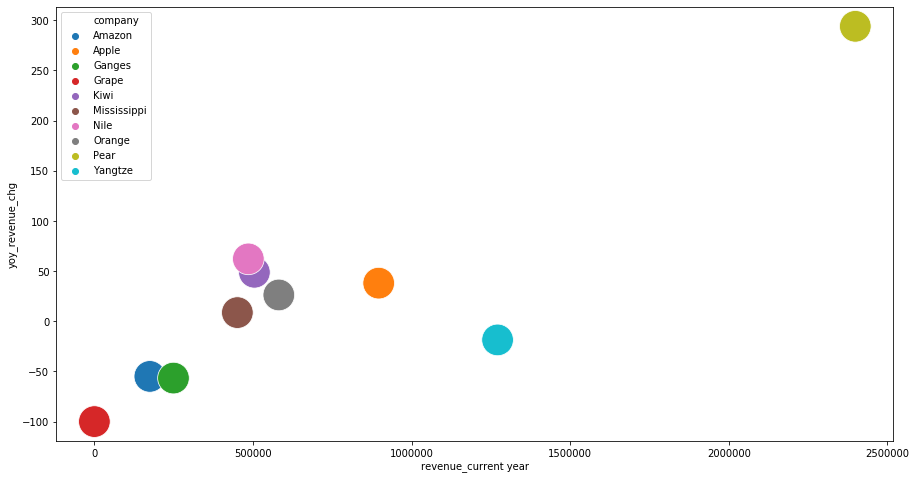

In [36]:
# basic plot showing revenue for current year vs YOY revenue change
plt.figure(figsize=(15,8))
g = sns.scatterplot(x='revenue_current year', y='yoy_revenue_chg', data=cust_df, hue='company', s=1000)

In [37]:
# unpivot for seaborn facet grid
melted_cust_df = pd.melt(cust_df, id_vars=['company'], value_vars=['revenue_current year', 'revenue_last year'])
melted_cust_df = melted_cust_df.sort_values('variable', ascending=False)
melted_cust_df = melted_cust_df.rename(columns={'variable':'period', 'value':'revenue'})
melted_cust_df['period'] = melted_cust_df['period'].str.replace('revenue_','')
melted_cust_df.head(2)

,company,period,revenue
10,Amazon,last year,388213.0
11,Apple,last year,649654.0


C:\Users\adamj\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


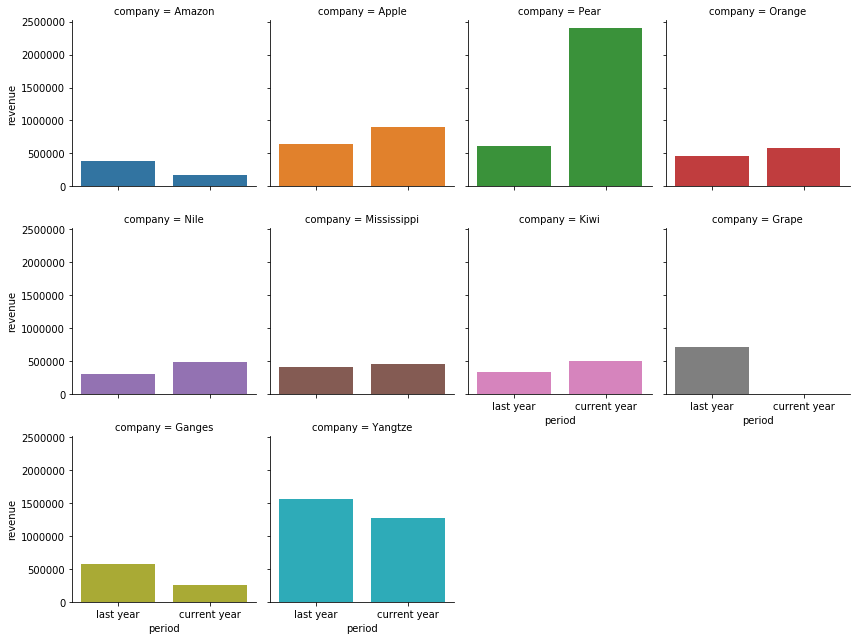

In [38]:
# YOY revenue bar plot by company
g = sns.FacetGrid(melted_cust_df, col='company', col_wrap=4, hue='company')
g = g.map(sns.barplot, 'period', 'revenue')

### Company Highlights
Company highlights and monthly analysis

In [39]:
def company_monthly_perf(df, company):
    """
    Returns a companies monthly revenue by month.
        
    Parameters:
        df: the dataframe being used to derive monthly data from.
        company: the company you want monthly revenue for
    """
    
    # filter by the company and group revenue by month
    c_df = df.loc[(last_24mos_df['company'] == company)]
    c_df = c_df.groupby(by=['date']).agg({'revenue': 'sum'}).reset_index()
    
    # get all months to merge with c_df (in case there are months with no revenue, this will show 0 for that month)
    m_df = df.groupby(by=df['date']).agg({'company': 'count'}).reset_index().drop(columns=['company'])
    
    # merge the two dataframes, filling NaN months with 0 for revenue
    cm_df = pd.merge(c_df, m_df, how='outer').fillna(0)
    cm_df = cm_df.sort_values('date', ascending=True)
    return cm_df

In [40]:
pear_mo_df = company_monthly_perf(last_24mos_df, 'Pear')
pear_mo_df.head(2)

,date,revenue
16,2017-10-01,0.0
17,2017-11-01,0.0


In [41]:
grape_mo_df = company_monthly_perf(last_24mos_df, 'Grape')
grape_mo_df.head(2)

,date,revenue
7,2017-10-01,0.0
0,2017-11-01,293.0


In [42]:
yangtze_mo_df = company_monthly_perf(last_24mos_df, 'Yangtze')
yangtze_mo_df.head(2)

,date,revenue
0,2017-10-01,122918
1,2017-11-01,130551


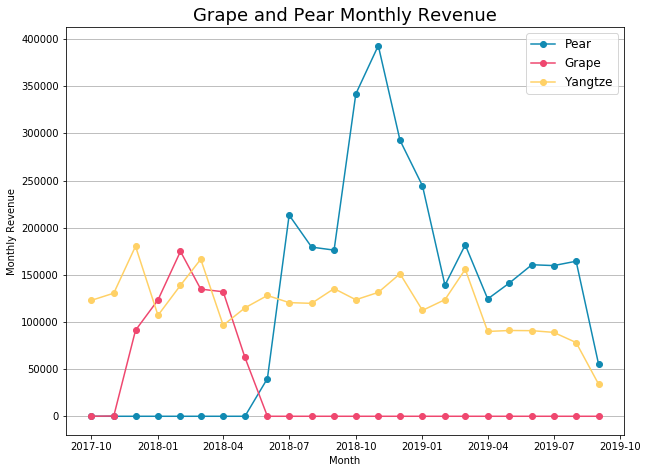

In [43]:
fig, axs = plt.subplots()
fig.set_size_inches(10, 7.5)
plt.plot(pear_mo_df['date'], pear_mo_df['revenue'], marker='o', c=colors[0])
plt.plot(grape_mo_df['date'], grape_mo_df['revenue'], marker='o', c=colors[1])
plt.plot(yangtze_mo_df['date'], yangtze_mo_df['revenue'], marker='o', c=colors[2])

plt.title("Grape and Pear Monthly Revenue", size=18)
plt.ylabel("Monthly Revenue")
plt.xlabel("Month")
plt.grid(axis='y')
plt.legend(['Pear', 'Grape', 'Yangtze'],loc="best", fontsize="large", fancybox=True)
plt.show()

### Customer Spend by Month

In [44]:
mon_rev_df = last_24mos_df.groupby(by=['date', 'company']).agg({'revenue': 'sum'}).reset_index()
mon_rev_df

,date,company,revenue
0,2017-10-01,Amazon,36844
1,2017-10-01,Apple,13817
2,2017-10-01,Ganges,52854
3,2017-10-01,Kiwi,16006
4,2017-10-01,Mississippi,42462
...,...,...,...
201,2019-09-01,Kiwi,16250
202,2019-09-01,Mississippi,5636
203,2019-09-01,Orange,8489
204,2019-09-01,Pear,55194


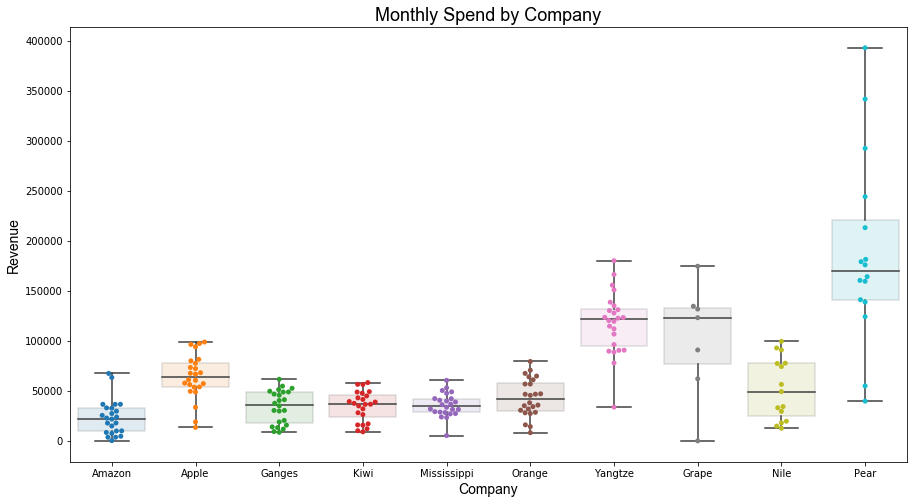

In [45]:
plt.figure(figsize=(15,8))
ax = sns.swarmplot(x="company", y="revenue", data=mon_rev_df, dodge=True)
ax = sns.boxplot(x="company", y="revenue", data=mon_rev_df, whis=np.inf, boxprops=dict(alpha=.15))
ax.set_ylabel("Revenue", fontname="Arial", fontsize=14)
ax.set_xlabel("Company", fontname="Arial", fontsize=14)
ax.set_title("Monthly Spend by Company", fontname='Arial', fontsize=18)
plt.show()

## Product Analysis
Will use the most recent rolling 24 months to hightlight current status and YOY change for products. Show the following product views:
 - Total revenue
 - YOY revenue change
 - Number of customer per product
 - YOY change in number of customers

### Year Over Year

In [46]:
# get year over year product revenue
prod_rev_pivot_df = last_24mos_df.pivot_table(index='product', columns='yoy_period', aggfunc={'revenue': 'sum'}).fillna(0)
prod_rev_df = flatten_cols(prod_rev_pivot_df)
prod_rev_df['yoy_revenue_chg'] = (prod_rev_df['revenue_current year'] / prod_rev_df['revenue_last year'] - 1) * 100
prod_rev_df = prod_rev_df.reset_index()

# drop experiment product type
prod_rev_df = prod_rev_df.replace([np.inf, -np.inf], np.nan).dropna()

prod_rev_df

,product,revenue_current year,revenue_last year,yoy_revenue_chg
0,Core,6114126.0,5379468.0,13.656704
2,New Business,1158.0,16142.0,-92.826168
3,Social,745213.0,513425.0,45.145445
4,Video Platform,150554.0,107212.0,40.426445


In [47]:
# get year over year customer count
prod_cust_pivot_df = last_24mos_df.pivot_table(index='product', columns='yoy_period', values='company',
                                              aggfunc=pd.Series.nunique).fillna(0)

# columns editing
prod_cust_df = prod_cust_pivot_df.rename(columns={'current year': 'customers_current year',
                                                'last year': 'customers_last year'})
cust_prod_df.columns.name = None

# add yoy change
prod_cust_df['yoy_customer_chg'] = (prod_cust_df['customers_current year'] / prod_cust_df['customers_last year'] - 1) * 100
prod_cust_df = prod_cust_df.reset_index()

# drop experiment product type
prod_cust_df = prod_cust_df.replace([np.inf, -np.inf], np.nan).dropna()

prod_cust_df

yoy_period,product,customers_current year,customers_last year,yoy_customer_chg
0,Core,9.0,10.0,-10.000000
2,New Business,1.0,3.0,-66.666667
3,Social,5.0,5.0,0.000000
4,Video Platform,5.0,5.0,0.000000


In [48]:
# merge the revenue and customer count dataframes
prod_df = pd.merge(prod_rev_df, prod_cust_df)
prod_df

,product,revenue_current year,revenue_last year,yoy_revenue_chg,customers_current year,customers_last year,yoy_customer_chg
0,Core,6114126.0,5379468.0,13.656704,9.0,10.0,-10.000000
1,New Business,1158.0,16142.0,-92.826168,1.0,3.0,-66.666667
2,Social,745213.0,513425.0,45.145445,5.0,5.0,0.000000
3,Video Platform,150554.0,107212.0,40.426445,5.0,5.0,0.000000


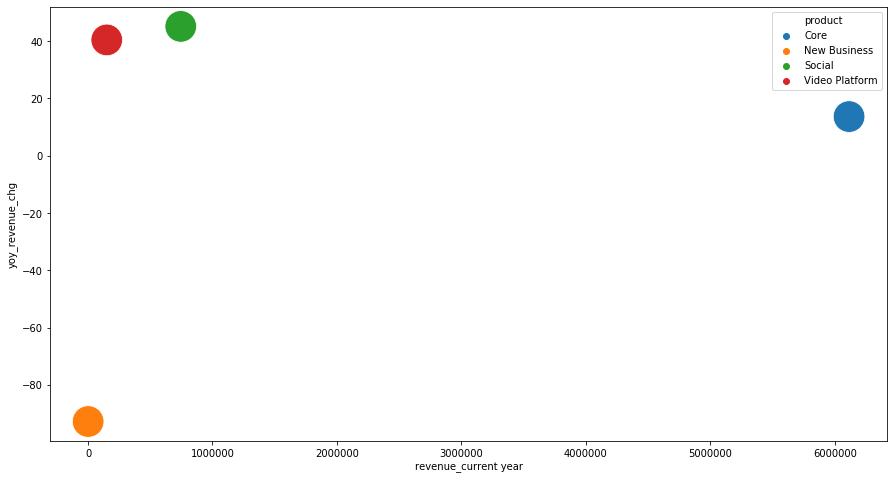

In [49]:
# basic plot showing revenue for current year vs YOY revenue change
plt.figure(figsize=(15,8))
g = sns.scatterplot(x='revenue_current year', y='yoy_revenue_chg', data=prod_df, hue='product', s=1000)

In [50]:
# unpivot for seaborn facet grid
melted_prod_df = pd.melt(prod_df, id_vars=['product'], value_vars=['revenue_current year', 'revenue_last year'])
melted_prod_df = melted_prod_df.sort_values('variable', ascending=False)
melted_prod_df = melted_prod_df.rename(columns={'variable':'period', 'value':'revenue'})
melted_prod_df['period'] = melted_prod_df['period'].str.replace('revenue_','')
melted_prod_df.head(2)

,product,period,revenue
4,Core,last year,5379468.0
5,New Business,last year,16142.0


C:\Users\adamj\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


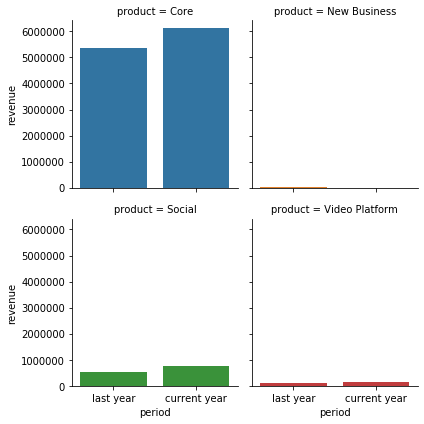

In [51]:
# YOY revenue bar plot by company
g = sns.FacetGrid(melted_prod_df, col='product', col_wrap=2, hue='product')
g = g.map(sns.barplot, 'period', 'revenue')

### Video Format

In [52]:
# create revenue by format df for last 2 years
vf_df = last_24mos_df.groupby(by=['date', 'format']).agg({'revenue': 'sum'}).unstack('format')
vf_df = flatten_cols(vf_df)
vf_df['total_revenue'] = vf_df['revenue_Display'] + vf_df['revenue_Video']
vf_df.head(2)

,revenue_Display,revenue_Video,total_revenue
date,,,
2017-10-01,289580,23662,313242
2017-11-01,309087,21141,330228


In [53]:
# convert to percentages
vf_perc_df = vf_df.div(vf_df['total_revenue'], axis=0) * 100 
vf_perc_df = vf_perc_df.reset_index()
vf_perc_df.head(2)

,date,revenue_Display,revenue_Video,total_revenue
0,2017-10-01,92.446096,7.553904,100.0
1,2017-11-01,93.598060,6.401940,100.0


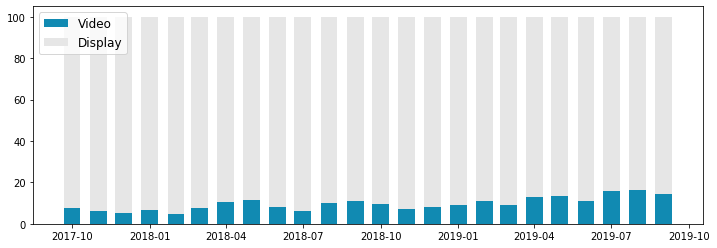

In [54]:
# plot the percent of revenue from video by month
plt.figure(figsize=(12,4))
ax1 = plt.bar(vf_perc_df['date'], vf_perc_df['revenue_Video'], width=20, color=colors[0])
ax2 = plt.bar(vf_perc_df['date'], vf_perc_df['revenue_Display'], width=20, bottom=vf_perc_df['revenue_Video'], color='#e6e6e6')
plt.legend(['Video', 'Display'],loc='upper left', fontsize=12, fancybox=True)
plt.show()